# Setup

In [1]:
import eval7 as ev7
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import joblib

In [2]:
RANKS = ['2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A']
SUITS = ['c', 'd', 'h', 's']

In [3]:
def ev7_hand_of_str_hand(str_hand):
    return [ev7.Card(str_hand[0:2]), ev7.Card(str_hand[2:4])]

def str_hand_of_ev7_hand(ev7_hand):
    rank0, suit0 = ev7_hand[0].rank, ev7_hand[0].suit
    rank1, suit1 = ev7_hand[1].rank, ev7_hand[1].suit
    if (rank0, suit0) <= (rank1, suit1):
        return f"{RANKS[rank1]}{SUITS[suit1]}{RANKS[rank0]}{SUITS[suit0]}"
    else:
        return f"{RANKS[rank0]}{SUITS[suit0]}{RANKS[rank1]}{SUITS[suit1]}"

def suit_ambigious_str_hand_of_str_hand(str_hand):
    rank0, suit0, rank1, suit1 = str_hand[0], str_hand[1], str_hand[2], str_hand[3]
    if rank0 == rank1: 
        return f"{rank0}{rank1}"
    elif suit0 == suit1:
        return f"{rank0}{rank1}s"
    else: 
        return f"{rank0}{rank1}o"

In [4]:
def calculate_equity_monte_carlo(hero_hands: list[list[str]], num_iterations: int) -> dict:

    raw_equity_dict = defaultdict(lambda: defaultdict(lambda: {'n': 0, 'wins_times_two': 0}))
    deck = ev7.Deck()

    n_hero_hands = len(hero_hands)
    doc_str = f"Hero-hand{'s ' if n_hero_hands > 1 else ' '}"
    doc_str += ", ".join(f"{hand}" for hand in hero_hands[:-1])
    if n_hero_hands > 1:
        doc_str += f" and {hero_hands[-1]}"

    print(doc_str)

    ev7_and_str_hhands = [(ev7_hand_of_str_hand(str_hhand), str_hhand) for str_hhand in hero_hands]

    for _ in tqdm(range(num_iterations), "Monte-carlo equity estimation"):

        ev7_vhand_and_board = deck.sample(7)
        ev7_vhand_and_board_set = set(ev7_vhand_and_board)
        ev7_board = ev7_vhand_and_board[2:7]
        str_vhand = str_hand_of_ev7_hand(ev7_vhand_and_board[0:2])
        sa_str_vhand = suit_ambigious_str_hand_of_str_hand(str_vhand)

        v_value = ev7.evaluate(ev7_vhand_and_board)

        for ev7_hhand, str_hhand in ev7_and_str_hhands: 

            # reject sample if there is a card repetition
            if any(ev7_card in ev7_vhand_and_board_set for ev7_card in ev7_hhand):
                continue 

            # increment hhand vs vhand count
            raw_equity_dict[str_hhand][sa_str_vhand]['n'] += 1

            # increment hhand vs vhand wins
            h_value = ev7.evaluate(ev7_hhand + ev7_board)
            if h_value > v_value:
                raw_equity_dict[str_hhand][sa_str_vhand]['wins_times_two'] += 2
            elif h_value == v_value:
                raw_equity_dict[str_hhand][sa_str_vhand]['wins_times_two'] += 1

                
    output_equity_dict = {}

    for str_hhand, all_vhands_equity_dict in raw_equity_dict.items():
        sa_str_hhand = suit_ambigious_str_hand_of_str_hand(str_hhand)
        output_equity_dict[sa_str_hhand] = {}
        for sa_str_vhand, vhand_equity_dict in all_vhands_equity_dict.items():
            n = vhand_equity_dict['n']
            equity = (vhand_equity_dict['wins_times_two'] / (2 * n)) if n > 0 else 0.0
            output_equity_dict[sa_str_hhand][sa_str_vhand] = {'equity': equity, 'n': n}
        
    return output_equity_dict

In [5]:
def plot_equity_matrix(hand, equity_dict):
    
    hand_equity_dict = equity_dict[hand]

    matrix = np.zeros((13, 13))  # 13x13 matrix for hand equities
    n_matrix = np.zeros((13, 13))  # matrix for number of runouts tested

    for current_hand, values in hand_equity_dict.items():
        equity = values['equity']
        n = values['n']
        rank1, rank2 = current_hand[0], current_hand[1]
        suited = current_hand.endswith('s')

        r_high, r_low = RANKS.index(rank1), RANKS.index(rank2)

        if suited:
            matrix[12 - r_high, 12 - r_low] = equity  # suited hands above the diagonal
            n_matrix[12 - r_high, 12 - r_low] = n
        elif r_high == r_low:
            matrix[12 - r_high, 12 - r_low] = equity  # paired hands on the diagonal
            n_matrix[12 - r_high, 12 - r_low] = n
        else:
            matrix[12 - r_low, 12 - r_high] = equity  # Offsuit hands below the diagonal
            n_matrix[12 - r_low, 12 - r_high] = n

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the matrix with a color map
    cax = ax.imshow(matrix, cmap='coolwarm', vmin=0, vmax=1)
    cbar = fig.colorbar(cax, ax=ax, label='Equity')
    cbar.formatter = FuncFormatter(lambda x, _: f'{x * 100:.0f}%')
    cbar.update_ticks()

    # Set ticks with reversed RANKS order to align with flippedmatrix
    ax.set_xticks(np.arange(13))
    ax.set_yticks(np.arange(13))
    ax.set_xticklabels(RANKS[::-1])  
    ax.set_yticklabels(RANKS[::-1])  

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(13):
        for j in range(13):
            equity_val = matrix[i, j]
            n_val = int(n_matrix[i, j])
            if equity_val > 0:
                # Determine hand notation
                if i == j:
                    current_hand = f'{RANKS[12 - j]}{RANKS[12 - i]}'  # Paired
                elif i < j:
                    current_hand = f'{RANKS[12 - i]}{RANKS[12 - j]}s'  # Suited
                else:
                    current_hand = f'{RANKS[12 - j]}{RANKS[12 - i]}o'  # Offsuit

                ax.text(j, i, f'{current_hand}\n{equity_val * 100:.0f}%\n({n_val})',
                        ha='center', va='center', color='black', fontsize=8)
                
    total_equity = 0
    for i in range(13):
        for j in range(13):
            total_equity += matrix[i][j] * n_matrix[i][j]
    average_equity = total_equity/np.sum(n_matrix)
    
    ax.set_title(f'{hand} Preflop Equity Heatmap (Average equity = {average_equity * 100:.0f}%)')
    plt.show()

# Simulation

In [6]:
hero_hands = []

for i in range(13):
    for j in range(i,13):
        hero_hands.append(f"{RANKS[j]}s{RANKS[i]}c")
        if i != j:
            hero_hands.append(f"{RANKS[j]}s{RANKS[i]}s")

In [7]:
equity_dict = calculate_equity_monte_carlo(hero_hands, num_iterations=10_000_000)

In [8]:
joblib.dump(equity_dict, "equity_dict.joblib")

# Plotting

In [9]:
equity_dict = joblib.load("equity_dict.joblib")

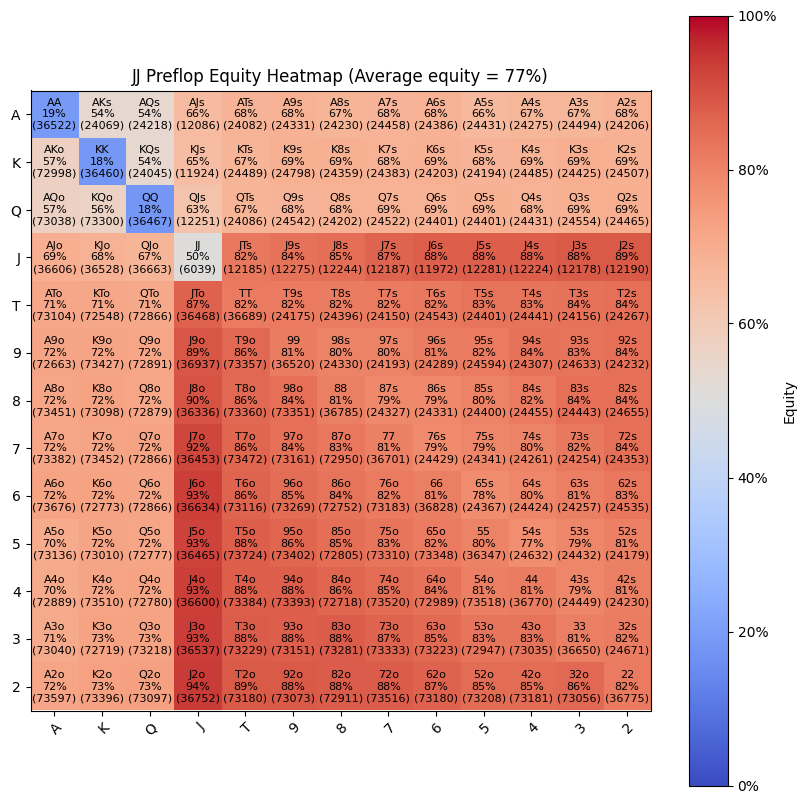

In [10]:
plot_equity_matrix("JJ", equity_dict) # no right way to play jiggities

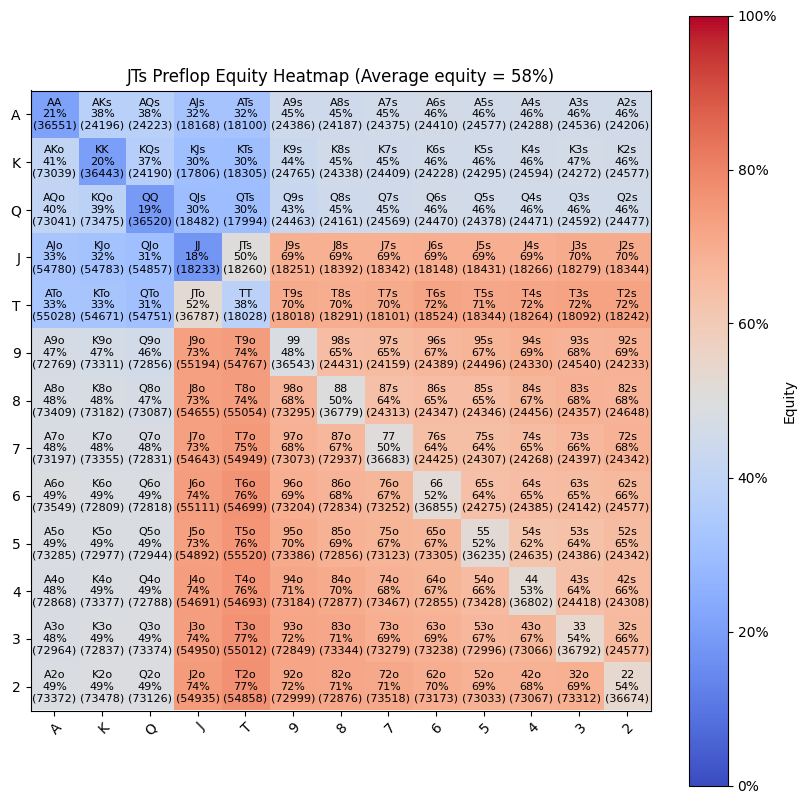

In [12]:
plot_equity_matrix("JTs", equity_dict) # jiggity tiggity suited

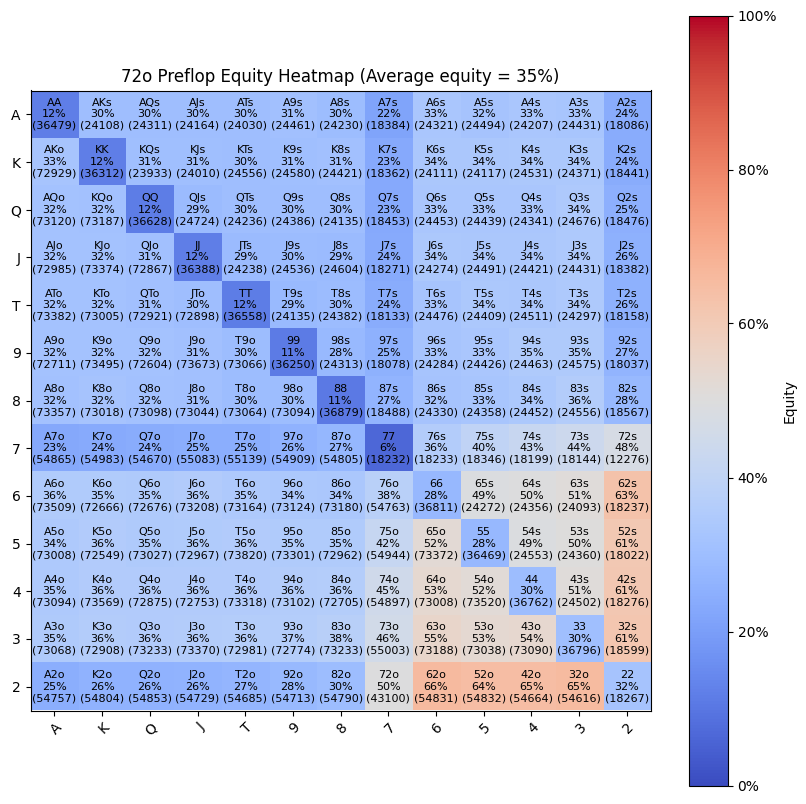

In [14]:
plot_equity_matrix("72o", equity_dict)

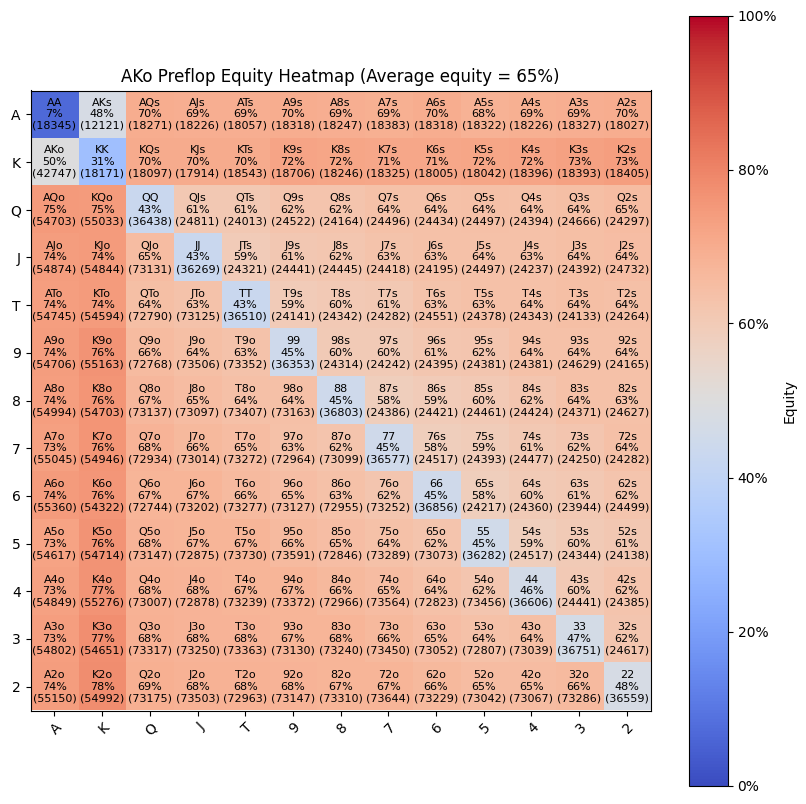

In [13]:
plot_equity_matrix("AKo", equity_dict)